In [2]:
#IMPORT LIBRARIES

from dolfin import *
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from __future__ import print_function
from IPython.display import clear_output as clc

plt.style.use("default")
set_log_level(LogLevel.ERROR)

In [3]:
# DEFINE COLORMAP

from matplotlib import colors
ice = sns.color_palette("icefire", as_cmap=True).colors
col = [ice[i] for i in np.concatenate((np.arange(128,0,-10), np.arange(254,128,-9)))]
col.insert(0, "black")
cmap = colors.LinearSegmentedColormap.from_list("", col)

# Unsteady Navier-Stokes equations

\begin{cases}
       \dfrac{\partial \mathbf{v}}{\partial t} -\nu \Delta \mathbf{v} + (\mathbf{v} \cdot \nabla) \mathbf{v} + \nabla p = 0  \qquad &\mathrm{in} \ \Omega(\boldsymbol{\mu}) \times (0,T] \\
       \mathrm{div }\  \mathbf{v} = 0  \qquad &\mathrm{in} \ \Omega(\boldsymbol{\mu}) \times (0,T) \\
       \mathbf{v} = \mathbf{v}_{\text{in}}(\boldsymbol{\mu})  \qquad &\mathrm{on} \ \Gamma_{\textrm{in}} \times (0,T)\\
       \mathbf{v} = \boldsymbol{0} \qquad &\mathrm{on} \ \Gamma_{\textrm{obs}} \times (0,T)\\
       \mathbf{v} \cdot \mathbf{n} = 0  \qquad &\mathrm{on} \ \Gamma_{\textrm{walls}} \times (0,T) \\
       (\mu \nabla \mathbf{v} - pI)\mathbf{n} \cdot \mathbf{t} = 0  \qquad &\mathrm{on} \ \Gamma_{\textrm{walls}} \times (0,T) \\
       (\mu \nabla \mathbf{v} - pI)\mathbf{n} = 0  \qquad &\mathrm{on} \ \Gamma_{\textrm{out}} \times (0,T)\\
       \mathbf{v} = \boldsymbol{0} &\mathrm{in} \ \Omega(\boldsymbol{\mu}) \times \{t = 0\}
\end{cases}

where $\Omega(\boldsymbol{\mu})$ is the domain of interest depending on the parameters $\boldsymbol{\mu}$ in the parameter space $\mathcal{P}$, $T > 0$ is the final time, $\mathbf{v}: \Omega \times [0,T] \to \mathbb{R}^2$ is the unknown velocity, $p: \Omega \times [0,T] \to \mathbb{R}$ is the unknown pressure, $\mathbf{v}_{\text{in}}(\boldsymbol{\mu}): \Gamma_{\textrm{in}} \times [0,T] \to \mathbb{R}^2$ is the time and parameters-dependent inflow datum, $\nu$ is the kynematic viscosity, $\mathbf{n}$ and $\mathbf{t}$ are the normal and tangential versors

In [ ]:
# MESH MORPHING

from scipy.interpolate import RBFInterpolator

def mesh_generator(obstacle_horizontal_semiaxis_left, obstacle_horizontal_semiaxis_right):
    """
    Mesh generation through RBF interpolation
    Input: geometric parameters representing the semi-major and semi-minor axis of the ellipsoidal obstacle
    Output: mesh with the proper obstacle
    """
    x_center = y_center = 1.0
    radius = 0.2
    mesh = Mesh("Data/FlowAroundObstacle_mesh_reference.xml")

    control_points = np.array([[x_center - radius, y_center], [x_center, y_center - radius], [x_center + radius, y_center], [x_center, y_center + radius]])
    displacements = np.array([[radius - obstacle_horizontal_semiaxis_left, 0.0], [0.0, 0.0], [obstacle_horizontal_semiaxis_right - radius, 0.0], [0.0, 0.0]])

    x0 = y0 = 0.0
    x1 = 10.0
    y1 = 2.0
    step_size = 0.1  
    wall1_points = np.column_stack((np.arange(x0, x1, step_size), np.zeros(round(x1/step_size))))
    wall2_points = np.column_stack((x1 * np.ones(round(y1/step_size)), np.arange(y0, y1, step_size)))
    wall3_points = np.column_stack((np.arange(x1, x0, -step_size), y1 * np.ones(round(x1/step_size))))
    wall4_points = np.column_stack((np.zeros(round(y1/step_size)), np.arange(y1, y0, -step_size)))
    
    control_points = np.row_stack((control_points, wall1_points, wall2_points, wall3_points, wall4_points))
    displacements = np.row_stack((displacements, np.zeros((wall1_points.shape[0] + wall2_points.shape[0] + wall3_points.shape[0] + wall4_points.shape[0], 2))))
    
    rbf = RBFInterpolator(control_points, displacements)
    displacements = rbf(mesh.coordinates())

    Dh = VectorFunctionSpace(mesh, "CG", 1)
    d = Function(Dh)
    v2d = vertex_to_dof_map(Dh).reshape((-1, mesh.geometry().dim()))
    for i in range(v2d.shape[0]):
        d.vector()[v2d[i]] = displacements[i]
    
    ALE.move(mesh, d)
    
    return mesh

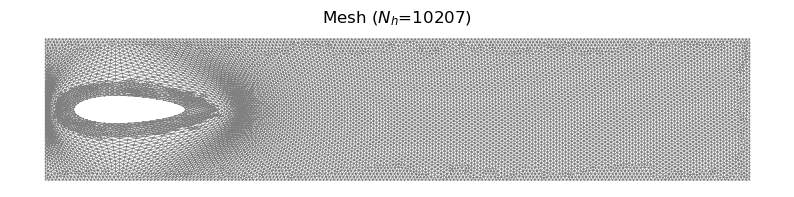

In [6]:
# MESH EXAMPLE (PLOT)

plt.figure(figsize = (10, 5))
mesh = mesh_generator(0.6, 1.0)
plot(mesh, color = "grey", linewidth = 0.5)
plt.title("Mesh ($N_{h}$=%d)" % mesh.num_vertices())
plt.axis('off');

In [7]:
# DEFINE THE UNSTEADY NAVIER-STOKES SOLVER

from tqdm import tqdm
    
def boundary_conditions(params_ph, Vh, Ph):
    '''
    Define boundary conditions (once for all)
    Input: physical parameters, velocity and pressure functional spaces
    Output: boundary conditions for velocity and pressure
    '''

    alpha_in = params_ph[0]
    mod_in = params_ph[1]
    
    # Parabolic BC on the inflow
    v_in = Expression(('mod_in * cos(alpha_in)','x[1] * (2.0 - x[1]) * mod_in * sin(alpha_in)'), degree = 2, mod_in = mod_in, alpha_in = alpha_in)  
    inflow = DirichletBC(Vh, v_in, "on_boundary && x[0] < 0.001")
    
    # Free-slip BC on the wall
    wall = DirichletBC(Vh.sub(1), 0.0, "on_boundary && (x[1] > 1.999 || x[1] < 0.001)")
    
    # No-slip BC on the obstacle
    obstacle = DirichletBC(Vh, (0.0, 0.0), "on_boundary && (x[0] - 1.0) * (x[0] - 1.0) + (x[1] - 1.0) *  (x[1] - 1.0) < 0.7 * 0.7")

    # BC for the velocity
    bcv = [inflow, wall, obstacle]
    
    # BC for the pressure required by Chorin-Temam method
    bcp = DirichletBC(Ph, 0.0, "on_boundary && x[0] > 9.999")
    
    return [bcv, bcp]

def chorin_assembly(Vh, Ph, dx):
    '''
    Assembly for the time-independent matrices of the Chorin steps
    Input: velocity and pressure functional spaces, space measure
    Outputs: assembled matrices
    '''
    
    w = TestFunction(Vh)
    q = TestFunction(Ph)
    v = TrialFunction(Vh)
    p = TrialFunction(Ph)

    # Second step
    a2 = inner(grad(p), grad(q)) * dx
    A2 = assemble(a2)
    
    # Third step
    a3 = inner(v, w) * dx
    A3 = assemble(a3)
    
    # Fourth step
    a4 = p * q * dx
    A4 = assemble(a4)
    
    return [A2, A3, A4] 
    
def compute_state(params, dt, ntimesteps):
    '''
    Compute unsteady velocity and pressure via incremental Chorin-Temam projection method
    Input: physical and geometric parameters, time step and number of time steps 
    Output: time-dependent velocity and pressure
    '''

    # Define parameters
    nu = 0.01                                          # Flow viscosity
    alpha_in = params[0][0]                            # Angle of attack
    mod_in = params[1][0]                              # Inflow intensity
    obstacle_horizontal_semiaxis_left = params[2][0]   # Obstacle horizontal left-semiaxis length
    obstacle_horizontal_semiaxis_right = params[3][0]  # Obstacle horizontal right-semiaxis length

    # Create mesh
    mesh = mesh_generator(obstacle_horizontal_semiaxis_left, obstacle_horizontal_semiaxis_right)
    
    # Define measures
    dx = Measure("dx", domain = mesh)
    ds = Measure("ds", domain = mesh)

    # Define functional spaces
    Vh = VectorFunctionSpace(mesh, "CG", 2)
    Ph = FunctionSpace(mesh, "CG", 1)

    # Define test functions    
    w = TestFunction(Vh)
    q = TestFunction(Ph)
    v = TrialFunction(Vh)
    p = TrialFunction(Ph)
    v1 = Function(Vh)
    p1 = Function(Ph)
    u = Function(Vh)

    # Define initial conditions
    v0 = Function(Vh)
    p0 = Function(Ph)
    
    # Chorin assembly for time-independent matrices
    [A2, A3, A4] = chorin_assembly(Vh, Ph, dx)
    
    vt = torch.zeros(ntimesteps, Vh.dim())
    pt = torch.zeros(ntimesteps, Ph.dim())
    
    i = 0
    t = float(dt)
    
    for i in tqdm(range(ntimesteps), colour = "cyan", file = sys.stdout, bar_format = 'Snapshots generation |{bar}| {n}/{total} {elapsed}<{remaining}'):
        
        # Compute boundary conditions
        [bcv, bcp] = boundary_conditions([params[0][i], params[1][i]], Vh, Ph)

        # First Chorin-Temam step
        a1 = (1 / dt) * inner(v, w) * dx + inner(grad(v) * v0, w) * dx + nu * inner(grad(v), grad(w)) * dx 
        A1 = assemble(a1)
        L1 = (1 / dt) * inner(v0, w) * dx - inner(grad(p0), w) * dx
        b1 = assemble(L1)
        [bc.apply(A1, b1) for bc in bcv]
        solve(A1, v1.vector(), b1)
        
        # Second Chorin-Temam step
        L2 = - (1 / dt) * div(v1) * q * dx
        b2 = assemble(L2)
        bcp.apply(A2, b2)
        solve(A2, p1.vector(), b2)
        
        # Third Chorin-Temam step
        L3 = inner(v1, w) * dx - dt * inner(grad(p1), w) * dx
        b3 = assemble(L3)
        solve(A3, v1.vector(), b3)
        
        # Fourth Chorin-Temam step
        L4 = p0 * q * dx + p1 * q * dx
        b4 = assemble(L4)
        solve(A4, p1.vector(), b4)
   
        v0.assign(v1)
        p0.assign(p1)
        vt[i] = torch.tensor(v1.vector())
        pt[i] = torch.tensor(p1.vector())
        i = i + 1
        t = t + float(dt)
    
    return [vt, pt]

# Snapshots generation

In [ ]:
# GENERATE SNAPSHOTS (SKIP THIS CELL IF DATA ALREADY AVAILABLE)

dt = Constant(0.05)
T = 10.0
ntimesteps = round(T / dt)
ntimes = ntimesteps # Time series length

ntrajectories = 100
nparams = 4
nvelocity = VectorFunctionSpace(Mesh("Data/FlowAroundObstacle_mesh_reference.xml"), "CG", 2).dim()
npressure = FunctionSpace(Mesh("Data/FlowAroundObstacle_mesh_reference.xml"), "CG", 1).dim()

params_ph_range = [(50, 400), (0, 2*pi), (1.0, 10.0)] # Physical parameters ranges: period and phase of time-dependent angle of attack and inflow intensity
params_geo_range = [(0.2, 0.6), (0.2, 1.0)]           # Geometric parameters ranges: obstacle horizontal semiaxes dimensions (left and right)
params_range = params_ph_range + params_geo_range

filename = 'Data/FlowAroundObstacle_UnsteadyParam_data'
V = torch.zeros(ntrajectories, ntimes, nvelocity)
P = torch.zeros(ntrajectories, ntimes, npressure)
MU = torch.zeros(ntrajectories, ntimes, nparams)

for i in range(ntrajectories):
 
    print(f"Generating snapshots n.{i}...")

    params = [0] * len(params_range)
    for j in range(len(params_range)):
        params[j] = ((params_range[j][1] - params_range[j][0]) * torch.rand(1) + params_range[j][0]).item()  
    
    alpha_in = []
    mod_in = []
    obstacle_horizontal_semiaxis_left = []
    obstacle_horizontal_semiaxis_right = []
    for j in range(ntimesteps):
        alpha_in.append(cos(2*pi*j/params[0] + params[1]))
        mod_in.append(params[2])
        obstacle_horizontal_semiaxis_left.append(params[3])
        obstacle_horizontal_semiaxis_right.append(params[4])

    params_ph = [alpha_in, mod_in]                                                       # Physical parameters: angle of attack and inflow intensity
    params_geo = [obstacle_horizontal_semiaxis_left, obstacle_horizontal_semiaxis_right] # Geometric parameters: obstacle horizontal semiaxes dimensions (left and right)

    [vt, pt] = compute_state(params_ph + params_geo, dt, ntimesteps)

    V[i] = vt
    P[i] = pt
    MU[i, :, 0] = torch.tensor(alpha_in)
    MU[i, :, 1] = torch.tensor(mod_in)
    MU[i, :, 2] = torch.tensor(obstacle_horizontal_semiaxis_left)
    MU[i, :, 3] = torch.tensor(obstacle_horizontal_semiaxis_right)

    clc(wait = True)

print("Snapshots generated!")

np.savez("%s.npz" % filename.replace(".npz",""), v = V, p = P, mu = MU)

In [8]:
# LOAD SNAPSHOTS MATRICES

dt = Constant(0.05)
T = 10.0
ntimesteps = round(T / dt)
ntimes = ntimesteps # Time series length

ntrajectories = 100
nparams = 4
nvelocity = VectorFunctionSpace(Mesh("Data/FlowAroundObstacle_mesh_reference.xml"), "CG", 2).dim()
npressure = FunctionSpace(Mesh("Data/FlowAroundObstacle_mesh_reference.xml"), "CG", 1).dim()

params_ph_range = [(50, 400), (0, 2*pi), (1.0, 10.0)] # Physical parameters ranges: period and phase of time-dependent angle of attack and inflow intensity
params_geo_range = [(0.2, 0.6), (0.2, 1.0)]           # Geometric parameters ranges: obstacle horizontal semiaxes dimensions (left and right)
params_range = params_ph_range + params_geo_range

filename = 'Data/FlowAroundObstacle_UnsteadyParam_data'
Data = np.load("%s.npz" % filename.replace(".npz",""))
V = torch.tensor(Data["v"])
P = torch.tensor(Data["p"])
MU = torch.tensor(Data["mu"])

In [9]:
# FUNCTIONS TO CONVERT VECTORS INTO FUNCTIONS

def vec2vel(vec, params_geo):
    '''
    Convert a vector into a fenics velocity function
    Input: vector of degrees of freedom and geometric parameters
    Output: function
    '''
    mesh = mesh_generator(params_geo[0], params_geo[1])
    Vh = VectorFunctionSpace(mesh, "CG", 2)
    v = Function(Vh)
    v.vector()[:] = vec
    return v
    
def vec2pre(vec, params):
    '''
    Convert a vector into a fenics pressure function
    Input: vector of degrees of freedom and geometric parameters
    Output: function
    '''
    mesh = mesh_generator(params_geo[0], params_geo[1])
    Ph = FunctionSpace(mesh, "CG", 1)
    p = Function(Ph)
    p.vector()[:] = vec
    return p

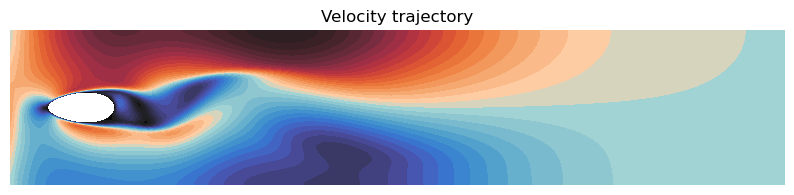

In [10]:
# VELOCITY TRAJECTORY EXAMPLE (PLOT)

from utils.processdata import trajectory

whichtrajectory = 0
whichtimes = torch.arange(0, 20)

params_geo = MU[whichtrajectory, 0, 2:]
vmin = V[whichtrajectory, whichtimes].abs().min()
vmax = V[whichtrajectory, whichtimes].abs().max()

def plot_velocity(v):
    v = vec2vel(v, params_geo)
    plot(sqrt(inner(v, v)), cmap = cmap, vmin = vmin, vmax = vmax)

trajectory(V[whichtrajectory, whichtimes], plot_velocity, title = "Velocity trajectory", figsize = (10, 10))

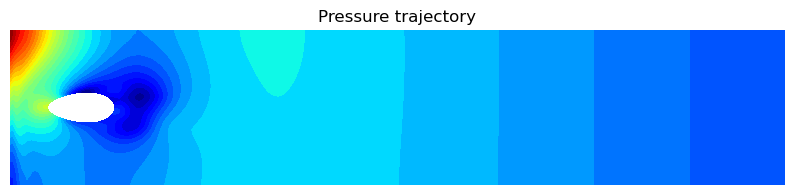

In [11]:
# PRESSURE TRAJECTORY EXAMPLE (PLOT)

whichtrajectory = 0
whichtimes = torch.arange(0, 20)

params_geo = MU[whichtrajectory, 0, 2:]

def plot_pressure(p):
    p = vec2pre(p, params_geo)
    plot(p, cmap = "jet")

trajectory(P[whichtrajectory, whichtimes], plot_pressure, title = "Pressure trajectory", figsize = (10, 10))

In [12]:
# TRAIN-VALIDATION-TEST SPLITTING

np.random.seed(0)

ntrain = round(0.8 * ntrajectories)

idx_train = np.random.choice(ntrajectories, size = ntrain, replace = False)
mask = np.ones(ntrajectories)
mask[idx_train] = 0
idx_valid_test = np.arange(0, ntrajectories)[np.where(mask!=0)[0]]
idx_valid = idx_valid_test[::2]
idx_test = idx_valid_test[1::2]

nvalid = idx_valid.shape[0]
ntest = idx_test.shape[0]

Vtrain = V[idx_train]
Vvalid = V[idx_valid]
Vtest = V[idx_test]
Ptrain = P[idx_train]
Pvalid = P[idx_valid]
Ptest = P[idx_test]
MUtrain = MU[idx_train]
MUvalid = MU[idx_valid]
MUtest = MU[idx_test]

In [13]:
# SPLIT VELOCITY MATRIX IN THE X AND Y COMPONENTS

Vx = V[:, :, 0 : nvelocity : 2]
Vy = V[:, :, 1 : nvelocity : 2]

Vxtrain = Vx[idx_train]
Vxvalid = Vx[idx_valid]
Vxtest = Vx[idx_test]
Vytrain = Vy[idx_train]
Vyvalid = Vy[idx_valid]
Vytest = Vy[idx_test]

# Velocity reduction - POD

In [24]:
# IMPORT FUNCTIONS FOR COMPUTING ERRORS

from utils.processdata import mae, mre, num2p # Error metrics and format

In [15]:
# RESHAPE MATRICES

Vxtrain = Vxtrain.reshape(-1, nvelocity//2).numpy()
Vxvalid = Vxvalid.reshape(-1, nvelocity//2).numpy()
Vxtest = Vxtest.reshape(-1, nvelocity//2).numpy()
Vytrain = Vytrain.reshape(-1, nvelocity//2).numpy()
Vyvalid = Vyvalid.reshape(-1, nvelocity//2).numpy()
Vytest = Vytest.reshape(-1, nvelocity//2).numpy()

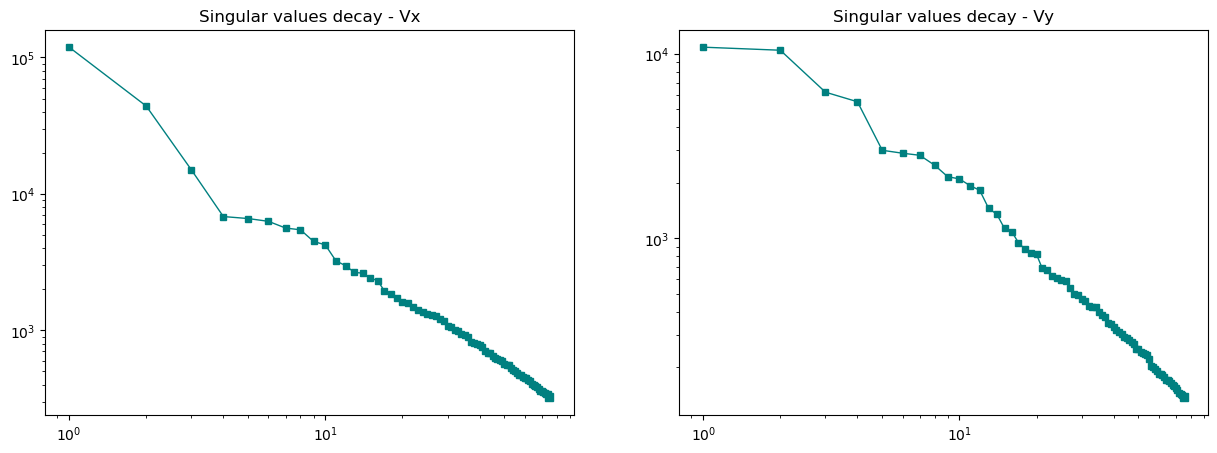

In [16]:
# PRINCIPAL ORTHOGONAL DECOMPOSITION

from sklearn.utils.extmath import randomized_svd

kvelocity = 150 # Number of POD modes

Ux, Sx, Wx = randomized_svd(Vxtrain, n_components = kvelocity//2)

Uy, Sy, Wy = randomized_svd(Vytrain, n_components = kvelocity//2)

teal = sns.light_palette("teal", 15)
plt.figure(figsize = (15, 5))
plt.subplot(1, 2, 1)
plt.plot([i for i in range(1, kvelocity//2 + 1)], Sx, color = teal[14], marker = 's', markersize = 5, linewidth = 1)
plt.ticklabel_format(axis = 'y', style = 'sci', scilimits = (0,0))
plt.loglog(kvelocity//2, Sx[kvelocity//2-1], color = teal[14], marker = 's', linestyle = '--')
plt.title("Singular values decay - Vx");

plt.subplot(1, 2, 2)
plt.plot([i for i in range(1, kvelocity//2 + 1)], Sy, color = teal[14], marker = 's', markersize = 5, linewidth = 1)
plt.ticklabel_format(axis = 'y', style = 'sci', scilimits = (0,0))
plt.loglog(kvelocity//2, Sy[kvelocity//2-1], color = teal[14], marker = 's', linestyle = '--')
plt.title("Singular values decay - Vy");

Vxtrain_POD = Vxtrain @ Wx.transpose()
Vxvalid_POD = Vxvalid @ Wx.transpose()
Vxtest_POD = Vxtest @ Wx.transpose()
Vxtrain_reconstructed = Ux @ np.diag(Sx) @ Wx
Vxvalid_reconstructed = Vxvalid @ Wx.transpose() @ Wx
Vxtest_reconstructed = Vxtest @ Wx.transpose() @ Wx

Vytrain_POD = Vytrain @ Wy.transpose()
Vyvalid_POD = Vyvalid @ Wy.transpose()
Vytest_POD = Vytest @ Wy.transpose()
Vytrain_reconstructed = Uy @ np.diag(Sy) @ Wy
Vyvalid_reconstructed = Vyvalid @ Wy.transpose() @ Wy
Vytest_reconstructed = Vytest @ Wy.transpose() @ Wy

In [17]:
# SCALING

from sklearn.preprocessing import MinMaxScaler

scalerVx = MinMaxScaler()
scalerVx = scalerVx.fit(Vxtrain_POD)
Vxtrain_POD = scalerVx.transform(Vxtrain_POD)
Vxvalid_POD = scalerVx.transform(Vxvalid_POD)
Vxtest_POD = scalerVx.transform(Vxtest_POD)

scalerVy = MinMaxScaler()
scalerVy = scalerVy.fit(Vytrain_POD)
Vytrain_POD = scalerVy.transform(Vytrain_POD)
Vyvalid_POD = scalerVy.transform(Vyvalid_POD)
Vytest_POD = scalerVy.transform(Vytest_POD)

In [18]:
# RESHAPE MATRICES

Vxtrain = torch.from_numpy(Vxtrain.reshape(ntrain, ntimes, nvelocity//2))
Vxvalid = torch.from_numpy(Vxvalid.reshape(nvalid, ntimes, nvelocity//2))
Vxtest = torch.from_numpy(Vxtest.reshape(ntest, ntimes, nvelocity//2))
Vxtrain_POD = torch.from_numpy(Vxtrain_POD.reshape(ntrain, ntimes, kvelocity//2))
Vxvalid_POD = torch.from_numpy(Vxvalid_POD.reshape(nvalid, ntimes, kvelocity//2))
Vxtest_POD = torch.from_numpy(Vxtest_POD.reshape(ntest, ntimes, kvelocity//2))
Vxtrain_reconstructed = torch.from_numpy(Vxtrain_reconstructed.reshape(ntrain, ntimes, nvelocity//2))
Vxvalid_reconstructed = torch.from_numpy(Vxvalid_reconstructed.reshape(nvalid, ntimes, nvelocity//2))
Vxtest_reconstructed = torch.from_numpy(Vxtest_reconstructed.reshape(ntest, ntimes, nvelocity//2))

Vytrain = torch.from_numpy(Vytrain.reshape(ntrain, ntimes, nvelocity//2))
Vyvalid = torch.from_numpy(Vyvalid.reshape(nvalid, ntimes, nvelocity//2))
Vytest = torch.from_numpy(Vytest.reshape(ntest, ntimes, nvelocity//2))
Vytrain_POD = torch.from_numpy(Vytrain_POD.reshape(ntrain, ntimes, kvelocity//2))
Vyvalid_POD = torch.from_numpy(Vyvalid_POD.reshape(nvalid, ntimes, kvelocity//2))
Vytest_POD = torch.from_numpy(Vytest_POD.reshape(ntest, ntimes, kvelocity//2))
Vytrain_reconstructed = torch.from_numpy(Vytrain_reconstructed.reshape(ntrain, ntimes, nvelocity//2))
Vyvalid_reconstructed = torch.from_numpy(Vyvalid_reconstructed.reshape(nvalid, ntimes, nvelocity//2))

Vytest_reconstructed = torch.from_numpy(Vytest_reconstructed.reshape(ntest, ntimes, nvelocity//2))

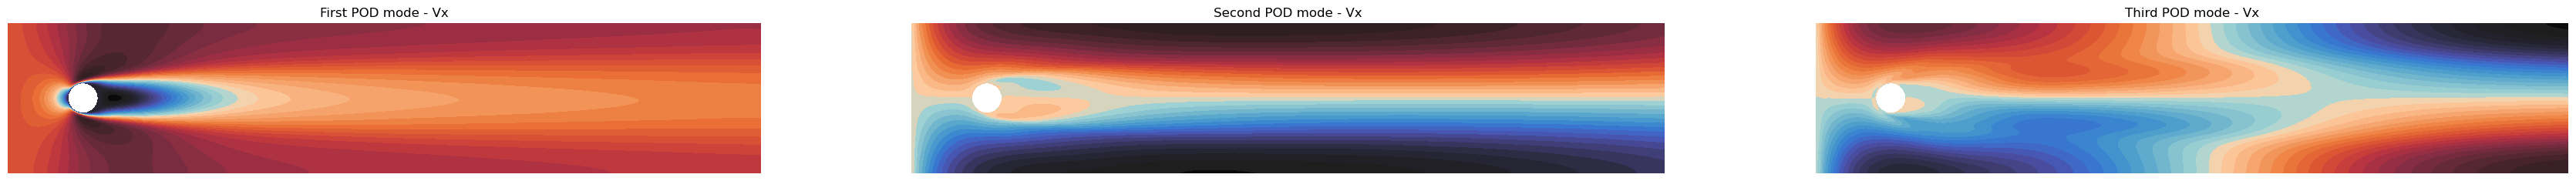

In [19]:
# POD MODES ON THE REFERENCE MESH (PLOT)

from utils.processdata import multiplot

plotlist = [Wx[0], Wx[1], Wx[2]]

def plot_vx(v):  
    mesh = mesh_generator(0.2, 0.2)
    Vh = VectorFunctionSpace(mesh, "CG", 2)
    vfun = Function(Vh.sub(0).collapse())
    vfun.vector()[:] = v  
    plot(vfun, cmap = cmap)

multiplot(plotlist, plot_vx, titles = ("First POD mode - Vx", "Second POD mode - Vx", "Third POD mode - Vx"), figsize = (300, 300))

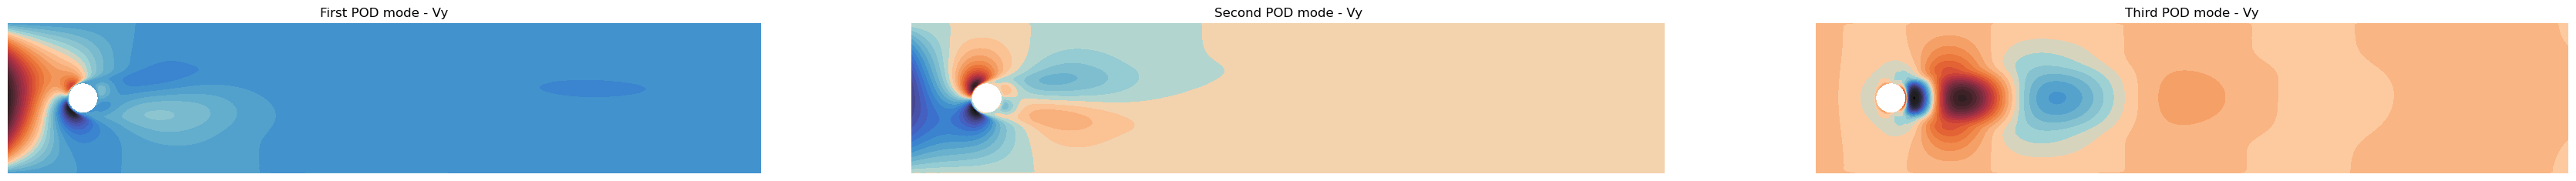

In [20]:
# POD MODES ON THE REFERENCE MESH (PLOT)

from utils.processdata import multiplot

plotlist = [Wy[0], Wy[1], Wy[2]]
def plot_vy(v):  
    mesh = mesh_generator(0.2, 0.2)
    Vh = VectorFunctionSpace(mesh, "CG", 2)
    vfun = Function(Vh.sub(1).collapse())
    vfun.vector()[:] = v  
    plot(vfun, cmap = cmap)

multiplot(plotlist, plot_vy, titles = ("First POD mode - Vy", "Second POD mode - Vy", "Third POD mode - Vy"), figsize = (300, 300))

In [22]:
# POD RECONSTRUCTION ERRORS ON TEST DATA

Vtest_reconstructed = torch.zeros(ntest, ntimes, nvelocity)
Vtest_reconstructed[:, :, 0 : nvelocity : 2] = Vxtest_reconstructed
Vtest_reconstructed[:, :, 1 : nvelocity : 2] = Vytest_reconstructed

print("Mean relative POD reconstruction error on V: %s" % num2p(mre(Vtest, Vtest_reconstructed)))

Mean relative POD reconstruction error on V: 1.51%


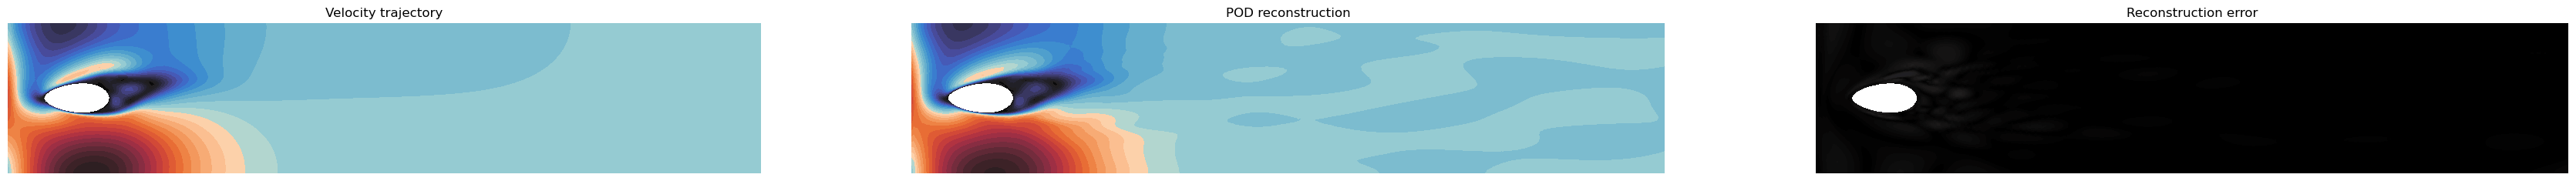

In [23]:
# FOM vs POD RECONSTRUCTION (PLOTS)

from utils.processdata import trajectories

whichtrajectory = 0
whichtimes = torch.arange(0, 20)

plotlist = [Vtest[whichtrajectory, whichtimes], Vtest_reconstructed[whichtrajectory, whichtimes], np.sqrt((Vtest[whichtrajectory, whichtimes] - Vtest_reconstructed[whichtrajectory, whichtimes])**2)]
params_geo = MU[whichtrajectory, 0, 2:]
vmin = min(np.abs(plotlist[i]).min() for i in range(len(plotlist)))
vmax = max(np.abs(plotlist[i]).max() for i in range(len(plotlist)))

trajectories(plotlist, plot_velocity, titles = ("Velocity trajectory", "POD reconstruction", "Reconstruction error"), figsize = (300, 300))

# SHRED-ROM

## Velocity sensors

In [ ]:
# EXTRACT SENSOR DATA (SKIP THIS CELL IF DATA ALREADY AVAILABLE)

nsensors = 3
idx_sensors = np.random.choice(nvelocity//2, size = nsensors, replace = False)

sensors_data_train = Vxtrain[:,:,idx_sensors]
sensors_data_valid = Vxvalid[:,:,idx_sensors]
sensors_data_test = Vxtest[:,:,idx_sensors]

In [ ]:
# LOAD SENSOR DATA

nsensors = 3
idx_sensors = torch.load('Data/FlowAroundObstacle_UnsteadyParam_idx_sensors_velocity.pt', weights_only = False)

sensors_data_train = Vxtrain[:,:,idx_sensors]
sensors_data_valid = Vxvalid[:,:,idx_sensors]
sensors_data_test = Vxtest[:,:,idx_sensors]

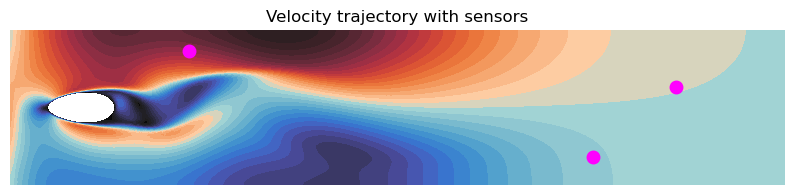

In [26]:
# TRAJECTORY WITH SENSORS (PLOT) 

def trajectory_with_sensors(vt, params_geo, idx_sensors, title = None):
    """
    Velocity trajectory with sensors
    Input: vvelocity trajectory with dimension (ntimes, nvelocity), geometric parameters and and the selected sensor indices
    """
    
    mesh = mesh_generator(params_geo[0], params_geo[1])
    Vh = VectorFunctionSpace(mesh, "CG", 2)
    sensors_coordinates = torch.from_numpy(Vh.sub(0).collapse().tabulate_dof_coordinates()[idx_sensors]).reshape(-1)
    v = Function(Vh)
    
    vmin = vt.abs().min()
    vmax = vt.abs().max()

    for i in range(vt.shape[0]):
        plt.figure(figsize=(10,10))
        v.vector()[:] = vt[i]
        plot(sqrt(inner(v, v)), cmap = cmap, vmin = vmin, vmax = vmax)
        for k in np.arange(0, nsensors * 2, 2):
            plt.plot(sensors_coordinates[k], sensors_coordinates[k+1], 'o', mfc = '#FF00FF', mec = '#FF00FF', ms = 8, mew = 2)
        plt.title(title)
        plt.axis('off')
        display(plt.gcf())
        plt.close()
        clc(wait=True)

whichtrajectory = 0
whichtimes = torch.arange(0, 20)

trajectory_with_sensors(V[whichtrajectory, whichtimes], MU[whichtrajectory, 0, 2:], idx_sensors, title = "Velocity trajectory with sensors")

In [27]:
# BUILD TRAIN, VALIDATION AND TEST DATASETS WITH PADDING

from utils.processdata import Padding, TimeSeriesDataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

lag = 50

train_data_in = Padding(torch.cat((sensors_data_train, MUtrain), 2), lag).to(device)
valid_data_in = Padding(torch.cat((sensors_data_valid, MUvalid), 2), lag).to(device)
test_data_in = Padding(torch.cat((sensors_data_test, MUtest), 2), lag).to(device)

train_data_out = Padding(torch.cat((Vxtrain_POD, Vytrain_POD), 2), 1).squeeze(1).to(device)
valid_data_out = Padding(torch.cat((Vxvalid_POD, Vyvalid_POD), 2), 1).squeeze(1).to(device)
test_data_out = Padding(torch.cat((Vxtest_POD, Vytest_POD), 2), 1).squeeze(1).to(device)

train_dataset = TimeSeriesDataset(train_data_in, train_data_out)
valid_dataset = TimeSeriesDataset(valid_data_in, valid_data_out)
test_dataset = TimeSeriesDataset(test_data_in, test_data_out)

In [ ]:
# SHRED TRAINING (SKIP THIS CELL IF SHRED ALREADY AVAILABLE)

from utils.models import SHRED, fit

shred = SHRED(nsensors + nparams, kvelocity, hidden_size = 64, hidden_layers = 2, decoder_sizes = [350, 400], dropout = 0.1).to(device)
train_errors, valid_errors = fit(shred, train_dataset, valid_dataset, batch_size = 64, epochs = 100, lr = 1e-3, verbose = True, patience = 100)

In [ ]:
# SHRED LOADING

from utils.models import SHRED, fit

shred = SHRED(nsensors + nparams, kvelocity, hidden_size = 64, hidden_layers = 2, decoder_sizes = [350, 400], dropout = 0.1).to(device)
shred.load_state_dict(torch.load('NN/FlowAroundObstacle_UnsteadyParam_shred_velocity.pt', weights_only = True));

In [30]:
# SHRED ERRORS ON TEST DATA

shred.freeze()

Vtest_POD_hat = shred(test_data_in).cpu()
Vxtest_hat = torch.from_numpy(scalerVx.inverse_transform(Vtest_POD_hat[:,:kvelocity//2])) @ Wx
Vytest_hat = torch.from_numpy(scalerVy.inverse_transform(Vtest_POD_hat[:,kvelocity//2:])) @ Wy

Vtest_hat = torch.zeros(ntest, ntimes, nvelocity)
Vtest_hat[:, :, 0 : nvelocity : 2] = Vxtest_hat.reshape(ntest, ntimes, nvelocity//2)
Vtest_hat[:, :, 1 : nvelocity : 2] = Vytest_hat.reshape(ntest, ntimes, nvelocity//2)

print("Mean relative SHRED prediction error on V: %s" % num2p(mre(Vtest, Vtest_hat)))

Mean relative SHRED prediction error on V: 9.34%


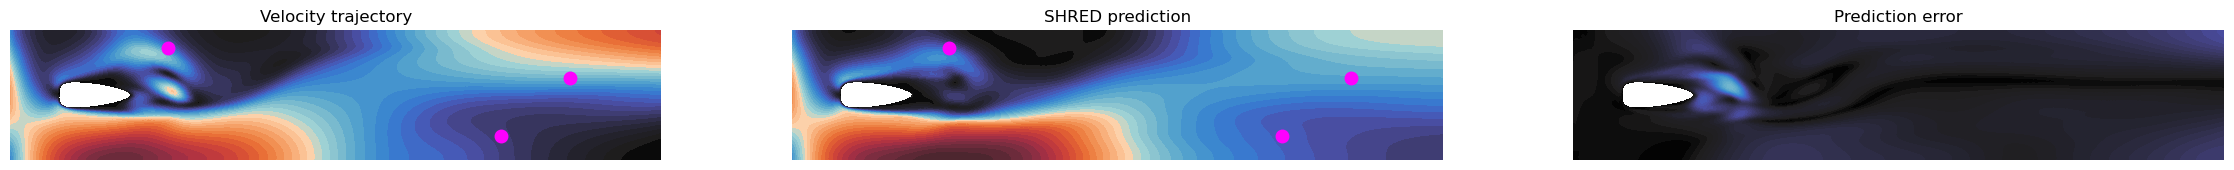

In [31]:
# FOM vs SHRED PREDICTION (PLOTS)

def trajectories_with_sensors(vts, params_geo, idx_sensors, titles = None):
    """
    Trajectories with sensors
    Input: list of trajectories with dimension (ntimes, nvelocity), geometric parameters and and the selected sensor indices
    """
    
    mesh = mesh_generator(params_geo[0], params_geo[1])
    Vh = VectorFunctionSpace(mesh, "CG", 2)
    sensors_coordinates = torch.from_numpy(Vh.sub(0).collapse().tabulate_dof_coordinates()[idx_sensors]).reshape(-1)
    v = Function(Vh)

    vmin = min(np.abs(plotlist[j]).min() for j in range(len(plotlist)))
    vmax = max(np.abs(plotlist[j]).max() for j in range(len(plotlist)))

    for i in range(vts[0].shape[0]):
        
        vmin = min(vts[j].abs().min() for j in range(len(vts)))
        vmax = max(vts[j].abs().max() for j in range(len(vts)))
        
        plt.figure(figsize = (200, 200))
        for j in range(len(vts)):
            plt.subplot(20, 20, j+1)
            v.vector()[:] = vts[j][i]
            plot(sqrt(inner(v, v)), cmap = cmap, vmin = vmin, vmax = vmax)
            if j < len(vts)-1:
               for k in np.arange(0, nsensors * 2, 2):
                   plt.plot(sensors_coordinates[k], sensors_coordinates[k+1], 'o', mfc = '#FF00FF', mec = '#FF00FF', ms = 8, mew = 2)
            plt.title(titles[j])
            plt.axis('off')
        
        display(plt.gcf())
        plt.close()
        clc(wait=True)
        
whichtrajectory = 0
whichtimes = torch.arange(180, 200)

plotlist = [Vtest[whichtrajectory, whichtimes], Vtest_hat[whichtrajectory, whichtimes], ((Vtest[whichtrajectory, whichtimes] - Vtest_hat[whichtrajectory, whichtimes])**2).sqrt()]

trajectories_with_sensors(plotlist, MUtest[whichtrajectory, 0, 2:], idx_sensors, titles = ("Velocity trajectory", "SHRED prediction", "Prediction error"))

## Velocity sensors - no parameters

In [ ]:
# EXTRACT SENSOR DATA (SKIP THIS CELL IF DATA ALREADY AVAILABLE)

nsensors = 3
idx_sensors = np.random.choice(nvelocity//2, size = nsensors, replace = False)

sensors_data_train = Vxtrain[:,:,idx_sensors]
sensors_data_valid = Vxvalid[:,:,idx_sensors]
sensors_data_test = Vxtest[:,:,idx_sensors]

In [ ]:
# LOAD SENSOR DATA

nsensors = 3

idx_sensors = torch.load('Data/FlowAroundObstacle_UnsteadyParam_idx_sensors_velocity.pt', weights_only = False)

sensors_data_train = Vxtrain[:,:,idx_sensors]
sensors_data_valid = Vxvalid[:,:,idx_sensors]
sensors_data_test = Vxtest[:,:,idx_sensors]

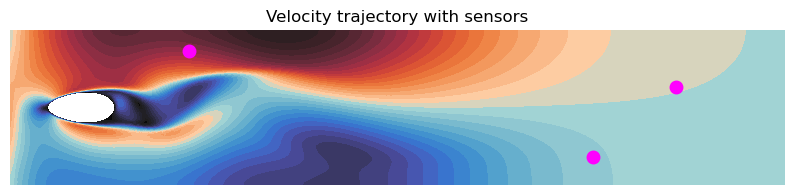

In [33]:
# TRAJECTORY WITH SENSORS (PLOT) 

def trajectory_with_sensors(vt, params_geo, idx_sensors, title = None):
    """
    Velocity trajectory with sensors
    Input: velocity trajectory with dimension (ntimes, nvelocity), geometric parameters and and the selected sensor indices
    """
    
    mesh = mesh_generator(params_geo[0], params_geo[1])
    Vh = VectorFunctionSpace(mesh, "CG", 2)
    sensors_coordinates = torch.from_numpy(Vh.sub(0).collapse().tabulate_dof_coordinates()[idx_sensors]).reshape(-1)
    v = Function(Vh)
    
    vmin = vt.abs().min()
    vmax = vt.abs().max()

    for i in range(vt.shape[0]):
        plt.figure(figsize=(10,10))
        v.vector()[:] = vt[i]
        plot(sqrt(inner(v, v)), cmap = cmap, vmin = vmin, vmax = vmax)
        for k in np.arange(0, nsensors * 2, 2):
            plt.plot(sensors_coordinates[k], sensors_coordinates[k+1], 'o', mfc = '#FF00FF', mec = '#FF00FF', ms = 8, mew = 2)
        plt.title(title)
        plt.axis('off')
        display(plt.gcf())
        plt.close()
        clc(wait=True)

whichtrajectory = 0
whichtimes = torch.arange(0, 20)

trajectory_with_sensors(V[whichtrajectory, whichtimes], MU[whichtrajectory, 0, 2:], idx_sensors, title = "Velocity trajectory with sensors")

In [34]:
# BUILD TRAIN, VALIDATION AND TEST DATASETS WITH PADDING

from utils.processdata import Padding, TimeSeriesDataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

lag = 50

train_data_in = Padding(sensors_data_train, lag).to(device)
valid_data_in = Padding(sensors_data_valid, lag).to(device)
test_data_in = Padding(sensors_data_test, lag).to(device)

train_data_out = Padding(torch.cat((Vxtrain_POD, Vytrain_POD), 2), 1).squeeze(1).to(device)
valid_data_out = Padding(torch.cat((Vxvalid_POD, Vyvalid_POD), 2), 1).squeeze(1).to(device)
test_data_out = Padding(torch.cat((Vxtest_POD, Vytest_POD), 2), 1).squeeze(1).to(device)

train_dataset = TimeSeriesDataset(train_data_in, train_data_out)
valid_dataset = TimeSeriesDataset(valid_data_in, valid_data_out)
test_dataset = TimeSeriesDataset(test_data_in, test_data_out)

In [ ]:
# SHRED TRAINING (SKIP THIS CELL IF SHRED ALREADY AVAILABLE)

from utils.models import SHRED, fit

shred = SHRED(nsensors, kvelocity, hidden_size = 64, hidden_layers = 2, decoder_sizes = [350, 400], dropout = 0.1).to(device)
train_errors, valid_errors = fit(shred, train_dataset, valid_dataset, batch_size = 64, epochs = 100, lr = 1e-3, verbose = True, patience = 100)

In [ ]:
# SHRED LOADING

from utils.models import SHRED, fit

shred = SHRED(nsensors, kvelocity, hidden_size = 64, hidden_layers = 2, decoder_sizes = [350, 400], dropout = 0.1).to(device)
shred.load_state_dict(torch.load('NN/FlowAroundObstacle_UnsteadyParam_shred_velocity_noparam.pt', weights_only = True));

In [37]:
# SHRED ERRORS ON TEST DATA

shred.freeze()

Vtest_POD_hat =  shred(test_data_in).cpu()

Vxtest_hat = torch.from_numpy(scalerVx.inverse_transform(Vtest_POD_hat[:,:kvelocity//2])) @ Wx
Vytest_hat = torch.from_numpy(scalerVy.inverse_transform(Vtest_POD_hat[:,kvelocity//2:])) @ Wy

Vtest_hat = torch.zeros(ntest, ntimes, nvelocity)
Vtest_hat[:, :, 0 : nvelocity : 2] = Vxtest_hat.reshape(ntest, ntimes, nvelocity//2)
Vtest_hat[:, :, 1 : nvelocity : 2] = Vytest_hat.reshape(ntest, ntimes, nvelocity//2)

print("Mean relative SHRED prediction error on V: %s" % num2p(mre(Vtest, Vtest_hat)))

Mean relative SHRED prediction error on V: 9.72%


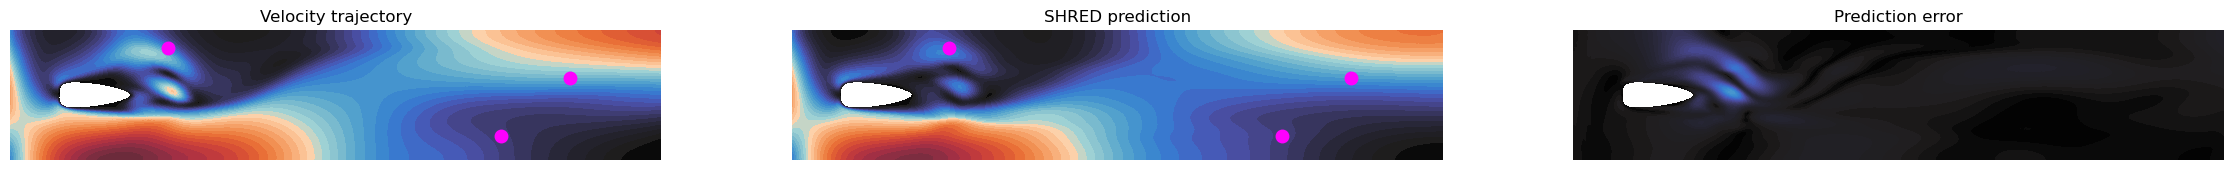

In [38]:
# FOM vs SHRED PREDICTION (PLOTS)

def trajectories_with_sensors(vts, params_geo, idx_sensors, titles = None):
    """
    Trajectories with sensors
    Input: list of trajectories with dimension (ntimes, nstate), geometric parameters and and the selected sensor indices
    """
    
    mesh = mesh_generator(params_geo[0], params_geo[1])
    Vh = VectorFunctionSpace(mesh, "CG", 2)
    sensors_coordinates = torch.from_numpy(Vh.sub(0).collapse().tabulate_dof_coordinates()[idx_sensors]).reshape(-1)
    v = Function(Vh)

    vmin = min(np.abs(plotlist[j]).min() for j in range(len(plotlist)))
    vmax = max(np.abs(plotlist[j]).max() for j in range(len(plotlist)))

    for i in range(vts[0].shape[0]):
        
        vmin = min(vts[j].abs().min() for j in range(len(vts)))
        vmax = max(vts[j].abs().max() for j in range(len(vts)))
        
        plt.figure(figsize = (200, 200))
        for j in range(len(vts)):
            plt.subplot(20, 20, j+1)
            v.vector()[:] = vts[j][i]
            plot(sqrt(inner(v, v)), cmap = cmap, vmin = vmin, vmax = vmax)
            if j < len(vts)-1:
               for k in np.arange(0, nsensors * 2, 2):
                   plt.plot(sensors_coordinates[k], sensors_coordinates[k+1], 'o', mfc = '#FF00FF', mec = '#FF00FF', ms = 8, mew = 2)
            plt.title(titles[j])
            plt.axis('off')
        
        display(plt.gcf())
        plt.close()
        clc(wait=True)
    
whichtrajectory = 0
whichtimes = torch.arange(180, 200)

plotlist = [Vtest[whichtrajectory, whichtimes], Vtest_hat[whichtrajectory, whichtimes], ((Vtest[whichtrajectory, whichtimes] - Vtest_hat[whichtrajectory, whichtimes])**2).sqrt()]

trajectories_with_sensors(plotlist, MUtest[whichtrajectory, 0, 2:], idx_sensors, titles = ("Velocity trajectory", "SHRED prediction", "Prediction error"))

## Velocity sensors - parameter estimation

In [ ]:
# EXTRACT SENSOR DATA (SKIP THIS CELL IF DATA ALREADY AVAILABLE)

nsensors = 3
idx_sensors = np.random.choice(nvelocity//2, size = nsensors, replace = False)

sensors_data_train = Vxtrain[:,:,idx_sensors]
sensors_data_valid = Vxvalid[:,:,idx_sensors]
sensors_data_test = Vxtest[:,:,idx_sensors]

In [ ]:
# LOAD SENSOR DATA

nsensors = 3
idx_sensors = torch.load('Data/FlowAroundObstacle_UnsteadyParam_idx_sensors_velocity.pt', weights_only = False)

sensors_data_train = Vxtrain[:,:,idx_sensors]
sensors_data_valid = Vxvalid[:,:,idx_sensors]
sensors_data_test = Vxtest[:,:,idx_sensors]

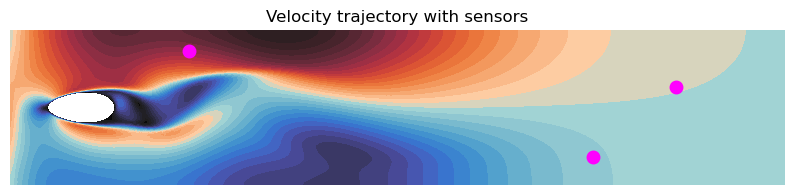

In [40]:
# TRAJECTORY WITH SENSORS (PLOT) 

def trajectory_with_sensors(vt, params_geo, idx_sensors, title = None):
    """
    Velocity trajectory with sensors
    Input: velocity trajectory with dimension (ntimes, nvelocity), geometric parameters and and the selected sensor indices
    """
    
    mesh = mesh_generator(params_geo[0], params_geo[1])
    Vh = VectorFunctionSpace(mesh, "CG", 2)
    sensors_coordinates = torch.from_numpy(Vh.sub(0).collapse().tabulate_dof_coordinates()[idx_sensors]).reshape(-1)
    v = Function(Vh)
    
    vmin = vt.abs().min()
    vmax = vt.abs().max()

    for i in range(vt.shape[0]):
        plt.figure(figsize=(10,10))
        v.vector()[:] = vt[i]
        plot(sqrt(inner(v, v)), cmap = cmap, vmin = vmin, vmax = vmax)
        for k in np.arange(0, nsensors * 2, 2):
            plt.plot(sensors_coordinates[k], sensors_coordinates[k+1], 'o', mfc = '#FF00FF', mec = '#FF00FF', ms = 8, mew = 2)
        plt.title(title)
        plt.axis('off')
        display(plt.gcf())
        plt.close()
        clc(wait=True)

whichtrajectory = 0
whichtimes = torch.arange(0, 20)

trajectory_with_sensors(V[whichtrajectory, whichtimes], MU[whichtrajectory, 0, 2:], idx_sensors, title = "Velocity trajectory with sensors")

In [41]:
# BUILD TRAIN, VALIDATION AND TEST DATASETS WITH PADDING

from utils.processdata import Padding, TimeSeriesDataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

lag = 50

train_data_in = Padding(sensors_data_train, lag).to(device)
valid_data_in = Padding(sensors_data_valid, lag).to(device)
test_data_in = Padding(sensors_data_test, lag).to(device)

train_data_out = Padding(torch.cat((Vxtrain_POD, Vytrain_POD, MUtrain[:,:,0].unsqueeze(2)), 2), 1).squeeze(1).to(device)
valid_data_out = Padding(torch.cat((Vxvalid_POD, Vyvalid_POD, MUvalid[:,:,0].unsqueeze(2)), 2), 1).squeeze(1).to(device)
test_data_out = Padding(torch.cat((Vxtest_POD, Vytest_POD, MUtest[:,:,0].unsqueeze(2)), 2), 1).squeeze(1).to(device)

train_dataset = TimeSeriesDataset(train_data_in, train_data_out)
valid_dataset = TimeSeriesDataset(valid_data_in, valid_data_out)
test_dataset = TimeSeriesDataset(test_data_in, test_data_out)

In [ ]:
# SHRED TRAINING (SKIP THIS CELL IF SHRED ALREADY AVAILABLE)

from utils.models import SHRED, fit

shred = SHRED(nsensors, kvelocity + 1, hidden_size = 64, hidden_layers = 2, decoder_sizes = [350, 400], dropout = 0.1).to(device)
train_errors, valid_errors = fit(shred, train_dataset, valid_dataset, batch_size = 64, epochs = 100, lr = 1e-3, verbose = True, patience = 100)

In [ ]:
# SHRED LOADING

from utils.models import SHRED, fit

shred = SHRED(nsensors, kvelocity + 1, hidden_size = 64, hidden_layers = 2, decoder_sizes = [350, 400], dropout = 0.1).to(device)
shred.load_state_dict(torch.load('NN/FlowAroundObstacle_UnsteadyParam_shred_velocity_paramestimation.pt', weights_only = True));

In [45]:
# SHRED ERRORS ON TEST DATA

mae = lambda datatrue, datapred: (datatrue - datapred).abs().mean()

shred.freeze()

test_dataset_out_hat = shred(test_data_in).cpu()

alpha_in_test_hat = test_dataset_out_hat[:,-1].reshape(ntest, ntimes)

Vtest_POD_hat = test_dataset_out_hat[:,:-1]
Vxtest_hat = torch.from_numpy(scalerVx.inverse_transform(Vtest_POD_hat[:,:kvelocity//2])) @ Wx
Vytest_hat = torch.from_numpy(scalerVy.inverse_transform(Vtest_POD_hat[:,kvelocity//2:])) @ Wy

Vtest_hat = torch.zeros(ntest, ntimes, nvelocity)
Vtest_hat[:, :, 0 : nvelocity : 2] = Vxtest_hat.reshape(ntest, ntimes, nvelocity//2)
Vtest_hat[:, :, 1 : nvelocity : 2] = Vytest_hat.reshape(ntest, ntimes, nvelocity//2)

print("Mean relative SHRED prediction error on V: %s" % num2p(mre(Vtest, Vtest_hat)))
print("Mean absolute SHRED prediction error on the angle of attack: %s" % round(mae(MUtest[:,:,0], alpha_in_test_hat).item(), 3))

Mean relative SHRED prediction error on V: 9.84%
Mean absolute SHRED prediction error on the angle of attack: 0.054


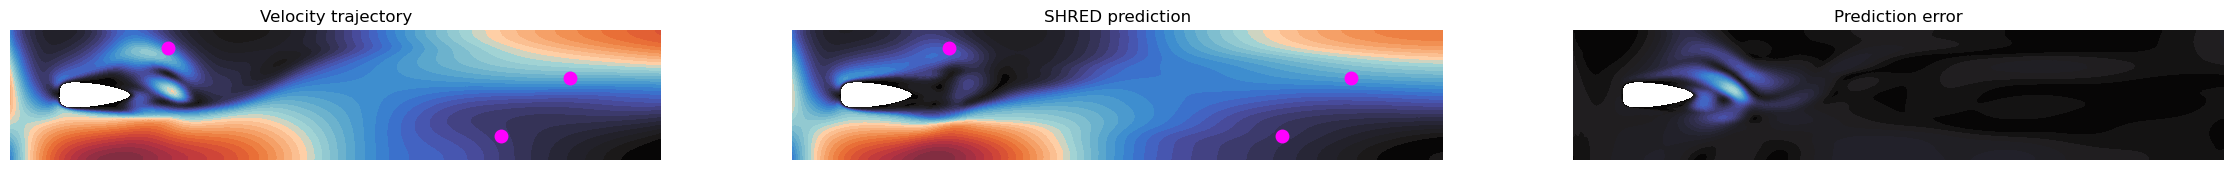

In [46]:
# FOM vs SHRED PREDICTION (PLOTS)

def trajectories_with_sensors(vts, params_geo, idx_sensors, titles = None):
    """
    Trajectories with sensors
    Input: list of trajectories with dimension (ntimes, nstate), geometric parameters and and the selected sensor indices
    """
    
    mesh = mesh_generator(params_geo[0], params_geo[1])
    Vh = VectorFunctionSpace(mesh, "CG", 2)
    sensors_coordinates = torch.from_numpy(Vh.sub(0).collapse().tabulate_dof_coordinates()[idx_sensors]).reshape(-1)
    v = Function(Vh)

    vmin = min(np.abs(plotlist[j]).min() for j in range(len(plotlist)))
    vmax = max(np.abs(plotlist[j]).max() for j in range(len(plotlist)))

    for i in range(vts[0].shape[0]):
        
        vmin = min(vts[j].abs().min() for j in range(len(vts)))
        vmax = max(vts[j].abs().max() for j in range(len(vts)))
        
        plt.figure(figsize = (200, 200))
        for j in range(len(vts)):
            plt.subplot(20, 20, j+1)
            v.vector()[:] = vts[j][i]
            plot(sqrt(inner(v, v)), cmap = cmap, vmin = vmin, vmax = vmax)
            if j < len(vts)-1:
               for k in np.arange(0, nsensors * 2, 2):
                   plt.plot(sensors_coordinates[k], sensors_coordinates[k+1], 'o', mfc = '#FF00FF', mec = '#FF00FF', ms = 8, mew = 2)
            plt.title(titles[j])
            plt.axis('off')
        
        display(plt.gcf())
        plt.close()
        clc(wait=True)
    
whichtrajectory = 0
whichtimes = torch.arange(180, 200)

plotlist = [Vtest[whichtrajectory, whichtimes], Vtest_hat[whichtrajectory, whichtimes], ((Vtest[whichtrajectory, whichtimes] - Vtest_hat[whichtrajectory, whichtimes])**2).sqrt()]

trajectories_with_sensors(plotlist, MUtest[whichtrajectory, 0, 2:], idx_sensors, titles = ("Velocity trajectory", "SHRED prediction", "Prediction error"))

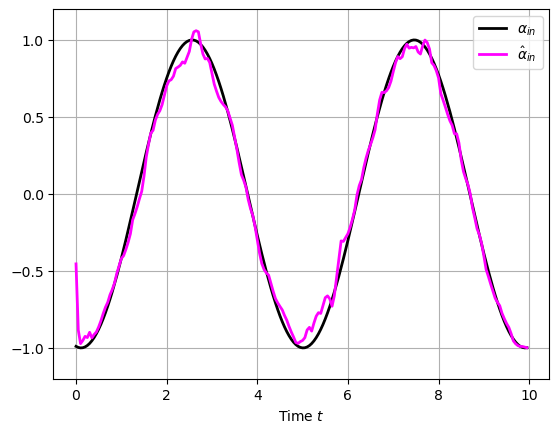

In [47]:
# PARAMETER vs SHRED PREDICTION (PLOT)

whichtrajectory = 0

times = torch.arange(0, T, float(dt))
plt.plot(times, MUtest[whichtrajectory,:,0], color = "black", linewidth = 2, label = r"$\alpha_{in}$")
plt.plot(times, alpha_in_test_hat[whichtrajectory], color = "magenta", linewidth = 2, label = r"$\hat {\alpha}_{in}$")
plt.ylim((-1.2, 1.2))
plt.grid()
plt.xlabel("Time $t$")
plt.legend()

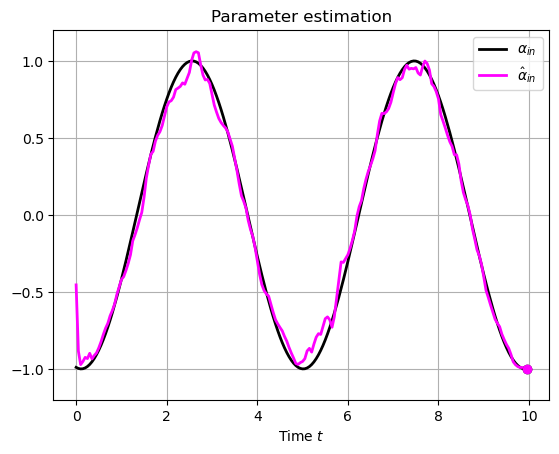

In [48]:
# PARAMETER vs SHRED PREDICTION (PLOT)

times = torch.arange(0, T, float(dt))

def trajectory_parameter_estimation(MU, MU_hat, title = None):
    """
    Trajectory for parameter estimation in time
    Input: ground truth trajectory and corresponding estimate
    """
    
    plt.figure(figsize = (7,5))
    for i in range(1, MU.shape[0] + 1):
        plt.plot(times[:i], MU[:i], color = "black", linewidth = 2, label = r"$\alpha_{in}$")
        plt.plot(times[:i], MU_hat[:i], color = "magenta", linewidth = 2, label = r"$\hat {\alpha}_{in}$")
        plt.plot(times[i-1], MU[i-1], 'o', color = "black")
        plt.plot(times[i-1], MU_hat[i-1], 'o', color = "magenta")
        if i < MU.shape[0]:
            plt.vlines(times[i-1], -2,  2, color = "lightgray")
        plt.grid()
        plt.xlabel("Time $t$")
        plt.xlim((times[0]-0.5, times[-1]+0.5))
        plt.ylim((-1.2, 1.2))
        plt.legend()
        plt.title(title)
        display(plt.gcf())
        plt.close()
        clc(wait=True)
    
whichtrajectory = 0

trajectory_parameter_estimation(MUtest[whichtrajectory,:,0], alpha_in_test_hat[whichtrajectory], title = ("Parameter estimation"))